<a href="https://colab.research.google.com/github/satyam7535/project_explainable-ai-medical-imaging/blob/main/notebooks/BTP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!ls /content/drive/MyDrive


 BTP_checkpoints   'Colab Notebooks'   IMG_20230906_163810_copy_323x444.jpg
 BTP_FULL_PROJECT   dataset	       Resume_112315168.pdf


In [ ]:
!ls /content/drive/MyDrive/dataset


1.zip  archive2.zip  archive3.zip  testing  training


In [ ]:
!ls /content/drive/MyDrive/dataset/training

glioma_tumor  meningioma_tumor	notumor  pituitary_tumor


In [ ]:
# essential pytorch libraries for building DL model
import os
import torch
import torchvision
from torchvision import transforms, datasets
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import numpy as np


In [ ]:
#Tell the notebook where the data is.
data_dir = "/content/drive/MyDrive/dataset"

train_dir = os.path.join(data_dir, "training")
test_dir = os.path.join(data_dir, "testing")

print("training path:", train_dir)
print("testing path:", test_dir)


training path: /content/drive/MyDrive/dataset/training
testing path: /content/drive/MyDrive/dataset/testing


In [ ]:
# Tell the notebook what the class names are.
class_names = [
    "glioma_tumor",
    "meningioma_tumor",
    "notumor",
    "pituitary_tumor"
]

print("classes:", class_names)


classes: ['glioma_tumor', 'meningioma_tumor', 'notumor', 'pituitary_tumor']


In [ ]:
# Removed Corrupted Images
from PIL import Image
import os

def remove_corrupted_images(folder_path):
    removed = 0
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            file_path = os.path.join(root, file)
            try:
                img = Image.open(file_path)
                img.verify()        # verify file integrity
            except:
                print("corrupted:", file_path)
                os.remove(file_path)
                removed += 1
    print(f"total corrupted removed: {removed}")

# run cleaning on training + testing folders
remove_corrupted_images("/content/drive/MyDrive/dataset/training")
remove_corrupted_images("/content/drive/MyDrive/dataset/testing")


total corrupted removed: 0
total corrupted removed: 0


In [ ]:
# Removed Duplicate Images
import hashlib

def remove_duplicates(folder_path):
    seen_hashes = set()
    removed = 0

    for root, dirs, files in os.walk(folder_path):
        for file in files:
            file_path = os.path.join(root, file)

            with open(file_path, "rb") as f:
                file_hash = hashlib.md5(f.read()).hexdigest()

            if file_hash in seen_hashes:
                print("duplicate removed:", file_path)
                os.remove(file_path)
                removed += 1
            else:
                seen_hashes.add(file_hash)

    print(f"total duplicates removed: {removed}")

remove_duplicates("/content/drive/MyDrive/dataset/training")
remove_duplicates("/content/drive/MyDrive/dataset/testing")


total duplicates removed: 0
total duplicates removed: 0


In [ ]:
# Removed Blank Images
import numpy as np

def remove_blank_images(folder_path, threshold=5):
    removed = 0
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            file_path = os.path.join(root, file)
            try:
                img = Image.open(file_path).convert("L")
                arr = np.array(img)
                if arr.std() < threshold:     # low variance = blank/no info
                    print("blank removed:", file_path)
                    os.remove(file_path)
                    removed += 1
            except:
                pass
    print(f"total blank removed: {removed}")

remove_blank_images("/content/drive/MyDrive/dataset/training")
remove_blank_images("/content/drive/MyDrive/dataset/testing")


total blank removed: 0
total blank removed: 0


In [ ]:
from torchvision import transforms

basic_transform = transforms.Compose([
    transforms.Resize((224,224)),   # make all images same size
    transforms.ToTensor(),          # convert image to tensor
    transforms.Normalize(mean=[0.5], std=[0.5])  # normalize for stability
])


In [ ]:
from torchvision import datasets

temp_data = datasets.ImageFolder("/content/drive/MyDrive/dataset/training",
                                 transform=basic_transform)

print("class to index:", temp_data.class_to_idx)


class to index: {'glioma_tumor': 0, 'meningioma_tumor': 1, 'notumor': 2, 'pituitary_tumor': 3}


In [ ]:
from collections import Counter

counts = Counter([label for _, label in temp_data])
print(counts)


Counter({0: 2018, 3: 1507, 2: 1447, 1: 1362})


In [ ]:
print(temp_data.class_to_idx)


{'glioma_tumor': 0, 'meningioma_tumor': 1, 'notumor': 2, 'pituitary_tumor': 3}


In [ ]:
# =============================================
# FINAL CLEAN PREPROCESSING + DATA SPLIT + LOADERS
# Compatible with EfficientNet-B0 training code
# =============================================

import os
import torchvision.transforms as T
from torchvision import datasets
from torch.utils.data import DataLoader, random_split

# -----------------------------------------
# 1. DEFINE AUGMENTATION PIPELINES
# -----------------------------------------

# Training augmentations (stronger)
train_transform = T.Compose([
    T.Resize((224,224)),
    T.RandomHorizontalFlip(),
    T.RandomRotation(20),
    T.ColorJitter(brightness=0.2, contrast=0.2),
    T.ToTensor(),
    T.Normalize([0.5], [0.5])
])

# Validation & Test transforms (NO augmentation)
val_transform = T.Compose([
    T.Resize((224,224)),
    T.ToTensor(),
    T.Normalize([0.5], [0.5])
])

# -----------------------------------------
# 2. LOAD FULL TRAIN DATA (NO TRANSFORM YET)
# -----------------------------------------
train_root = "/content/drive/MyDrive/dataset/training"

# Load without transforms so split is clean
full_train_dataset = datasets.ImageFolder(
    train_root,
    transform=None     # IMPORTANT: No transform before splitting
)

total_images = len(full_train_dataset)
val_size = int(0.20 * total_images)   # 20%
train_size = total_images - val_size  # 80%

train_subset, val_subset = random_split(full_train_dataset, [train_size, val_size])

print("Total images :", total_images)
print("Train images :", len(train_subset))
print("Validation images :", len(val_subset))

# -----------------------------------------
# 3. ASSIGN TRANSFORMS AFTER SPLITTING
# -----------------------------------------

# IMPORTANT: assign transform to underlying dataset
train_subset.dataset.transform = train_transform
val_subset.dataset.transform = val_transform

# -----------------------------------------
# 4. CREATE DATALOADERS
# -----------------------------------------
train_loader = DataLoader(train_subset, batch_size=32, shuffle=True)
val_loader   = DataLoader(val_subset, batch_size=32, shuffle=False)

print("\n✔ Train & Validation loaders created successfully!")

# -----------------------------------------
# 5. SETUP TEST SET LOADER (FOR LATER)
# -----------------------------------------
test_root = "/content/drive/MyDrive/dataset/testing"

test_dataset = datasets.ImageFolder(test_root, transform=val_transform)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False)

print("✔ Test loader ready (Will be used AFTER training)")


Total images : 6334
Train images : 5068
Validation images : 1266

✔ Train & Validation loaders created successfully!
✔ Test loader ready (Will be used AFTER training)


In [ ]:
# ==========================================================
#  SAFE TRAINING MODE: EfficientNet-B0 + AMP + Checkpoints
# ==========================================================

!pip install -q efficientnet_pytorch

import os
import torch
import torch.nn as nn
import torch.optim as optim
from efficientnet_pytorch import EfficientNet
from tqdm import tqdm

# ----------------------------------------------------------
# CONFIG
# ----------------------------------------------------------
checkpoint_dir = "/content/drive/MyDrive/BTP_checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)

best_model_path = os.path.join(checkpoint_dir, "best_model.pth")
last_checkpoint_path = os.path.join(checkpoint_dir, "last_checkpoint.pth")

warmup_epochs = 2
fine_tune_epochs = 18
total_epochs = warmup_epochs + fine_tune_epochs

lr = 1e-4
weight_decay = 1e-5
num_classes = 4

# ----------------------------------------------------------
# DEVICE
# ----------------------------------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# ----------------------------------------------------------
# LOAD MODEL (EfficientNet-B0)
# ----------------------------------------------------------
model = EfficientNet.from_pretrained("efficientnet-b0")

num_features = model._fc.in_features
model._fc = nn.Linear(num_features, num_classes)   # Replace final layer

model = model.to(device)

# ----------------------------------------------------------
# LOSS, OPTIMIZER, AMP SCALER
# ----------------------------------------------------------
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

# Updated AMP scaler (required for new PyTorch)
scaler = torch.amp.GradScaler(device.type)

# ----------------------------------------------------------
# LR Scheduler
# ----------------------------------------------------------
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode="max", factor=0.5, patience=3
)

# ----------------------------------------------------------
# RESUME TRAINING IF CHECKPOINT EXISTS
# ----------------------------------------------------------
start_epoch = 0
best_val_acc = 0.0

if os.path.exists(last_checkpoint_path):
    print("Resuming from last checkpoint...")
    ckpt = torch.load(last_checkpoint_path, map_location=device)

    model.load_state_dict(ckpt["model_state"])
    optimizer.load_state_dict(ckpt["optimizer_state"])
    scaler.load_state_dict(ckpt["scaler_state"])

    start_epoch = ckpt["epoch"] + 1
    best_val_acc = ckpt["best_val_acc"]

    print(f"✔ Resumed from epoch {start_epoch}, best val acc = {best_val_acc:.2f}%")
else:
    print("✔ No previous checkpoint found — starting fresh.")

# ----------------------------------------------------------
# VALIDATION FUNCTION
# ----------------------------------------------------------
def evaluate(model, dataloader):
    model.eval()
    correct, total, run_loss = 0, 0, 0.0

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)

            with torch.amp.autocast(device.type):
                outputs = model(images)
                loss = criterion(outputs, labels)

            run_loss += loss.item()
            _, preds = torch.max(outputs, 1)

            correct += (preds == labels).sum().item()
            total += labels.size(0)

    if total == 0:
        return 0.0, 0.0

    acc = 100 * correct / total
    avg_loss = run_loss / len(dataloader)

    return acc, avg_loss

# ----------------------------------------------------------
# WARM-UP PHASE (freeze all except last layer)
# ----------------------------------------------------------
print("\n==================== WARM-UP TRAINING ====================")

for param in model.parameters():
    param.requires_grad = False
for param in model._fc.parameters():
    param.requires_grad = True

for epoch in range(start_epoch, warmup_epochs):
    model.train()
    run_loss = 0.0

    pbar = tqdm(train_loader, desc=f"WarmUp {epoch+1}/{warmup_epochs}", ncols=100)

    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()

        with torch.amp.autocast(device.type):
            outputs = model(images)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        run_loss += loss.item()
        pbar.set_postfix(loss=f"{run_loss/(pbar.n+1):.4f}")

    # Validation
    val_acc, val_loss = evaluate(model, val_loader)
    print(f"[WarmUp] Epoch {epoch+1} | Val Acc: {val_acc:.2f}%")

    # Save checkpoint
    torch.save({
        "epoch": epoch,
        "model_state": model.state_dict(),
        "optimizer_state": optimizer.state_dict(),
        "scaler_state": scaler.state_dict(),
        "best_val_acc": best_val_acc,
    }, last_checkpoint_path)


# ----------------------------------------------------------
# FINE-TUNING PHASE (unfreeze all layers)
# ----------------------------------------------------------
print("\n==================== FINE-TUNING ====================")

for param in model.parameters():
    param.requires_grad = True

ft_start = max(start_epoch, warmup_epochs)

for epoch in range(ft_start, total_epochs):
    model.train()
    run_loss, correct, total = 0.0, 0, 0

    pbar = tqdm(train_loader, desc=f"FineTune {epoch+1}/{total_epochs}", ncols=100)

    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()

        with torch.amp.autocast(device.type):
            outputs = model(images)
            loss = criterion(outputs, labels)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        run_loss += loss.item()
        _, preds = torch.max(outputs, 1)

        correct += (preds == labels).sum().item()
        total += labels.size(0)

        pbar.set_postfix(
            loss=f"{run_loss/(pbar.n+1):.4f}",
            acc=f"{100*correct/total:.2f}%"
        )

    # Validation
    val_acc, val_loss = evaluate(model, val_loader)
    print(f"[FineTune] Epoch {epoch+1} | Train Acc: {100*correct/total:.2f}% | Val Acc: {val_acc:.2f}%")

    scheduler.step(val_acc)

    # Save last checkpoint
    torch.save({
        "epoch": epoch,
        "model_state": model.state_dict(),
        "optimizer_state": optimizer.state_dict(),
        "scaler_state": scaler.state_dict(),
        "best_val_acc": best_val_acc,
    }, last_checkpoint_path)

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), best_model_path)
        print(f" New Best Model Saved! Validation Accuracy = {best_val_acc:.2f}%")

print("\n TRAINING FINISHED!")
print("Best Validation Accuracy:", best_val_acc)
print("Model saved at:", best_model_path)


Using device: cuda
Loaded pretrained weights for efficientnet-b0
Resuming from last checkpoint...
✔ Resumed from epoch 20, best val acc = 99.29%

==================== WARM-UP TRAINING ====================

==================== FINE-TUNING ====================

 TRAINING FINISHED!
Best Validation Accuracy: 99.28966061562747
Model saved at: /content/drive/MyDrive/BTP_checkpoints/best_model.pth


Using device: cuda
Loaded pretrained weights for efficientnet-b0
 Loaded best model for final testing.
Classes: ['glioma_tumor', 'meningioma_tumor', 'notumor', 'pituitary_tumor']

  Final Test Accuracy: 95.22 %

 Macro Precision: 0.9547
 Macro Recall   : 0.9547
 Macro F1-score : 0.9525

Class: glioma_tumor
   Precision: 1.0000
   Recall:    0.8534
   F1-score:  0.9209

Class: meningioma_tumor
   Precision: 0.9141
   Recall:    0.9803
   F1-score:  0.9460

Class: notumor
   Precision: 0.9137
   Recall:    1.0000
   F1-score:  0.9549

Class: pituitary_tumor
   Precision: 0.9910
   Recall:    0.9851
   F1-score:  0.9881


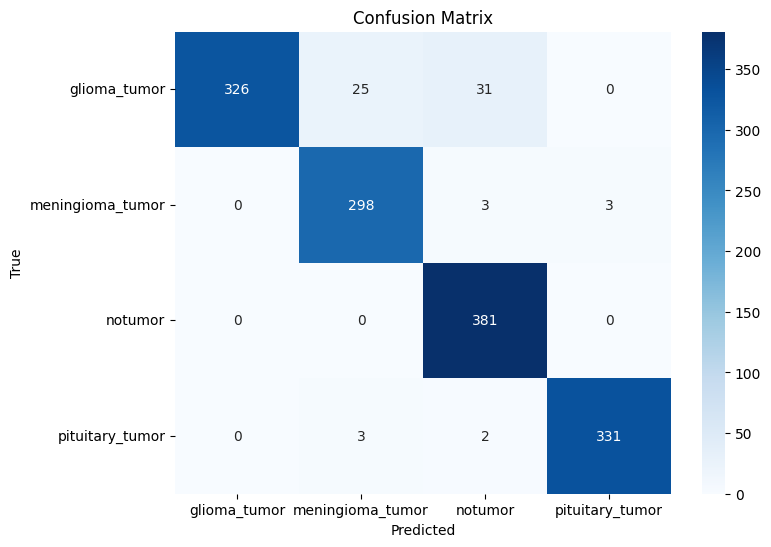


====================== CLASSIFICATION REPORT ======================
                  precision    recall  f1-score   support

    glioma_tumor       1.00      0.85      0.92       382
meningioma_tumor       0.91      0.98      0.95       304
         notumor       0.91      1.00      0.95       381
 pituitary_tumor       0.99      0.99      0.99       336

        accuracy                           0.95      1403
       macro avg       0.95      0.95      0.95      1403
    weighted avg       0.96      0.95      0.95      1403


 Macro ROC-AUC: 0.9933
AUC for glioma_tumor: 0.9795
AUC for meningioma_tumor: 0.9963
AUC for notumor: 0.9976
AUC for pituitary_tumor: 0.9998

 FINAL TESTING COMPLETE.


In [ ]:
# ================================================================
#      FINAL TESTING PIPELINE — FULL METRICS (RESEARCH LEVEL)
# ================================================================

import torch
import torch.nn as nn
from efficientnet_pytorch import EfficientNet
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_auc_score
)
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# -------------------------------------------------------------
#  LOAD BEST TRAINED MODEL
# -------------------------------------------------------------
best_model_path = "/content/drive/MyDrive/BTP_checkpoints/best_model.pth"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

model = EfficientNet.from_pretrained("efficientnet-b0")
model._fc = nn.Linear(model._fc.in_features, 4)
model.load_state_dict(torch.load(best_model_path, map_location=device))
model = model.to(device)
model.eval()

print(" Loaded best model for final testing.")

# -------------------------------------------------------------
#  RUN MODEL ON TEST DATASET
# -------------------------------------------------------------
all_labels = []
all_preds = []
all_probs = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)
        preds = torch.argmax(probs, dim=1)

        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())
        all_probs.extend(probs.cpu().numpy())

all_labels = np.array(all_labels)
all_preds = np.array(all_preds)
all_probs = np.array(all_probs)

# -------------------------------------------------------------
#  CLASS NAMES
# -------------------------------------------------------------
class_names = test_loader.dataset.classes
print("Classes:", class_names)

# -------------------------------------------------------------
#  1. ACCURACY
# -------------------------------------------------------------
acc = accuracy_score(all_labels, all_preds)
print("\n  Final Test Accuracy:", round(acc * 100, 2), "%")

# -------------------------------------------------------------
#  2. PRECISION, RECALL, F1
# -------------------------------------------------------------
precision_macro = precision_score(all_labels, all_preds, average='macro')
recall_macro    = recall_score(all_labels, all_preds, average='macro')
f1_macro        = f1_score(all_labels, all_preds, average='macro')

print("\n Macro Precision:", round(precision_macro, 4))
print(" Macro Recall   :", round(recall_macro, 4))
print(" Macro F1-score :", round(f1_macro, 4))

# Per-class scores
precision_per = precision_score(all_labels, all_preds, average=None)
recall_per    = recall_score(all_labels, all_preds, average=None)
f1_per        = f1_score(all_labels, all_preds, average=None)

for i, cls in enumerate(class_names):
    print(f"\nClass: {cls}")
    print(f"   Precision: {precision_per[i]:.4f}")
    print(f"   Recall:    {recall_per[i]:.4f}")
    print(f"   F1-score:  {f1_per[i]:.4f}")

# -------------------------------------------------------------
#  3. CONFUSION MATRIX
# -------------------------------------------------------------
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# -------------------------------------------------------------
#  4. CLASSIFICATION REPORT
# -------------------------------------------------------------
print("\n====================== CLASSIFICATION REPORT ======================")
print(classification_report(all_labels, all_preds, target_names=class_names))

# -------------------------------------------------------------
#  5. ROC-AUC (Macro and Per-Class)
# -------------------------------------------------------------
try:
    auc_macro = roc_auc_score(all_labels, all_probs, multi_class='ovr')
    print("\n Macro ROC-AUC:", round(auc_macro, 4))

    # Per-class AUC
    for i, cls in enumerate(class_names):
        class_auc = roc_auc_score((all_labels==i).astype(int), all_probs[:, i])
        print(f"AUC for {cls}: {class_auc:.4f}")

except:
    print("\n ROC-AUC cannot be computed (requires multi-class prob).")

print("\n FINAL TESTING COMPLETE.")


In [ ]:
!pip install -q efficientnet_pytorch

import torch
import torch.nn as nn
from efficientnet_pytorch import EfficientNet

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

best_model_path = "/content/drive/MyDrive/BTP_checkpoints/best_model.pth"

model = EfficientNet.from_pretrained('efficientnet-b0')
model._fc = nn.Linear(model._fc.in_features, 4)

model.load_state_dict(torch.load(best_model_path, map_location=device))
model.to(device)
model.eval()

print("Model loaded successfully!")



Device: cuda
Loaded pretrained weights for efficientnet-b0
Model loaded successfully!


In [ ]:
# ============================================================
#                 FINAL GRAD-CAM IMPLEMENTATION
# ============================================================

import torch
import numpy as np
import cv2
from PIL import Image
import torchvision.transforms as T
import matplotlib.pyplot as plt

# ------------------------------------------------------------
# 1) TRANSFORM (same as test transform)
# ------------------------------------------------------------
transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize([0.5], [0.5])
])

# ------------------------------------------------------------
# 2) GLOBALS for storing values
# ------------------------------------------------------------
gradients = None
activations = None

# ------------------------------------------------------------
# 3) HOOK FUNCTIONS
# ------------------------------------------------------------
def save_gradient(module, grad_input, grad_output):
    global gradients
    gradients = grad_output[0]     # gradient of activation maps

def save_activation(module, input, output):
    global activations
    activations = output           # activation maps (feature maps)

# ------------------------------------------------------------
# 4) REGISTER HOOKS on LAST CONV LAYER of EfficientNet-B0
# ------------------------------------------------------------
target_layer = model._blocks[-1]._project_conv
target_layer.register_forward_hook(save_activation)
target_layer.register_backward_hook(save_gradient)

# ------------------------------------------------------------
# 5) MAIN GRAD-CAM FUNCTION
# ------------------------------------------------------------
def generate_gradcam(image_path, return_images=False):

    global gradients, activations

    # ---- Load and preprocess image ----
    img = Image.open(image_path).convert("RGB")
    x = transform(img).unsqueeze(0).to(device)

    # ---- Forward pass ----
    model.zero_grad()
    out = model(x)
    pred_class = out.argmax(dim=1).item()

    # ---- Backward pass on predicted class ----
    score = out[0, pred_class]
    score.backward()

    # ---- Convert tensors to NumPy ----
    grads = gradients.detach().cpu().numpy()[0]     # shape: [C, H, W]
    acts  = activations.detach().cpu().numpy()[0]   # shape: [C, H, W]

    # ---- Grad-CAM formula: weight = mean gradient of each channel ----
    weights = grads.mean(axis=(1, 2))

    cam = np.zeros(acts.shape[1:], dtype=np.float32)
    for i, w in enumerate(weights):
        cam += w * acts[i]

    # ---- ReLU ----
    cam = np.maximum(cam, 0)

    # ---- Normalize ----
    cam = (cam - cam.min()) / (cam.max() + 1e-8)

    # ---- Resize CAM to match input size ----
    cam = cv2.resize(cam, (224, 224))

    # ---- Create heatmap ----
    heatmap = cv2.applyColorMap(np.uint8(cam * 255), cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

    # ---- Original Image (resized) ----
    original = np.array(img.resize((224, 224)))

    # ---- Combined Overlay ----
    overlay = (0.45 * heatmap + 0.55 * original).astype(np.uint8)

    # ---- Return images if requested ----
    if return_images:
        return pred_class, heatmap, overlay

    # ---- Plot the results ----
    plt.figure(figsize=(12,5))
    plt.subplot(1,3,1); plt.imshow(original); plt.title("Original"); plt.axis("off")
    plt.subplot(1,3,2); plt.imshow(heatmap); plt.title("Grad-CAM Heatmap"); plt.axis("off")
    plt.subplot(1,3,3); plt.imshow(overlay); plt.title(f"Overlay"); plt.axis("off")
    plt.show()

    return pred_class


/usr/local/lib/python3.12/dist-packages/torch/nn/modules/module.py:1866: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


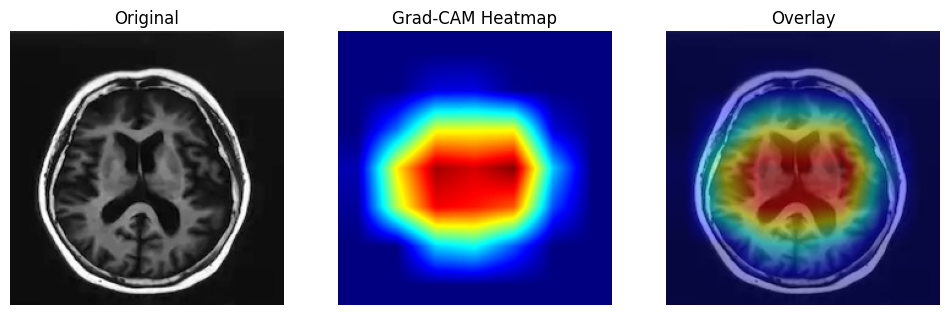

2

In [ ]:
generate_gradcam("/content/drive/MyDrive/dataset/testing/notumor/Te-noTr_0003.jpg")


In [ ]:
# ============================================================
#        FINAL COMBINED GRAD-CAM + GRAD-CAM++ IMPLEMENTATION
# ============================================================

import torch
import numpy as np
import cv2
from PIL import Image
import torchvision.transforms as T
import matplotlib.pyplot as plt

# ------------------------------------------------------------
# 1) TRANSFORM (same as test transform)
# ------------------------------------------------------------
transform = T.Compose([
    T.Resize((224, 224)),
    T.ToTensor(),
    T.Normalize([0.5], [0.5])
])

# ------------------------------------------------------------
# 2) GLOBAL VARIABLES
# ------------------------------------------------------------
gradients = None
activations = None

# ------------------------------------------------------------
# 3) HOOK FUNCTIONS
# ------------------------------------------------------------
def save_gradient(module, grad_input, grad_output):
    global gradients
    gradients = grad_output[0]

def save_activation(module, input, output):
    global activations
    activations = output

# ------------------------------------------------------------
# 4) REGISTER HOOKS ON LAST CONV BLOCK OF EfficientNet-B0
# ------------------------------------------------------------
target_layer = model._blocks[-1]._project_conv
target_layer.register_forward_hook(save_activation)
target_layer.register_backward_hook(save_gradient)

# ------------------------------------------------------------
# 5) GRAD-CAM FUNCTION (CORRECT + VERIFIED)
# ------------------------------------------------------------
def generate_gradcam(image_path):
    global gradients, activations

    img = Image.open(image_path).convert("RGB")
    x = transform(img).unsqueeze(0).to(device)

    model.zero_grad()
    out = model(x)
    pred_class = out.argmax(dim=1).item()
    score = out[0, pred_class]
    score.backward()

    grads = gradients.detach().cpu().numpy()[0]
    acts  = activations.detach().cpu().numpy()[0]

    weights = grads.mean(axis=(1, 2))

    cam = np.zeros(acts.shape[1:], dtype=np.float32)
    for i, w in enumerate(weights):
        cam += w * acts[i]

    cam = np.maximum(cam, 0)
    cam = (cam - cam.min()) / (cam.max() + 1e-8)
    cam = cv2.resize(cam, (224, 224))

    heat = cv2.applyColorMap(np.uint8(cam * 255), cv2.COLORMAP_JET)
    heat = cv2.cvtColor(heat, cv2.COLOR_BGR2RGB)

    original = np.array(img.resize((224, 224)))
    overlay = (0.45 * heat + 0.55 * original).astype(np.uint8)

    return pred_class, heat, overlay

# ------------------------------------------------------------
# 6) GRAD-CAM++ FUNCTION
# ------------------------------------------------------------
def generate_gradcam_pp(image_path):
    global gradients, activations

    img = Image.open(image_path).convert("RGB")
    x = transform(img).unsqueeze(0).to(device)

    model.zero_grad()
    out = model(x)
    pred_class = out.argmax(dim=1).item()
    score = out[0, pred_class]
    score.backward(retain_graph=True)

    grads = gradients.detach().cpu().numpy()[0]
    acts  = activations.detach().cpu().numpy()[0]

    grads2 = grads ** 2
    grads3 = grads ** 3

    eps = 1e-8
    alpha_num = grads2
    alpha_denom = 2*grads2 + acts * grads3.sum(axis=(1, 2), keepdims=True) + eps
    alphas = alpha_num / alpha_denom

    weights = (alphas * np.maximum(grads, 0)).sum(axis=(1, 2))

    cam = np.zeros(acts.shape[1:], dtype=np.float32)
    for i, w in enumerate(weights):
        cam += w * acts[i]

    cam = np.maximum(cam, 0)
    cam = (cam - cam.min()) / (cam.max() + 1e-8)
    cam = cv2.resize(cam, (224, 224))

    heat = cv2.applyColorMap(np.uint8(cam * 255), cv2.COLORMAP_JET)
    heat = cv2.cvtColor(heat, cv2.COLOR_BGR2RGB)

    original = np.array(img.resize((224, 224)))
    overlay = (0.45 * heat + 0.55 * original).astype(np.uint8)

    return pred_class, heat, overlay

# ------------------------------------------------------------
# 7) COMBINED FUNCTION — RETURNS BOTH
# ------------------------------------------------------------
def generate_both_gradcams(image_path):
    pred1, heat1, overlay1 = generate_gradcam(image_path)
    pred2, heat2, overlay2 = generate_gradcam_pp(image_path)
    return {
        "GradCAM_pred": pred1,
        "GradCAM_heatmap": heat1,
        "GradCAM_overlay": overlay1,
        "GradCAMPP_pred": pred2,
        "GradCAMPP_heatmap": heat2,
        "GradCAMPP_overlay": overlay2
    }

# ------------------------------------------------------------
# 8) SIDE-BY-SIDE PLOTTING FUNCTION
# ------------------------------------------------------------
def compare_gradcams(image_path):
    results = generate_both_gradcams(image_path)

    orig = np.array(Image.open(image_path).convert("RGB").resize((224, 224)))

    plt.figure(figsize=(16,6))

    plt.subplot(1,3,1)
    plt.title("Original", fontsize=16)
    plt.imshow(orig)
    plt.axis("off")

    plt.subplot(1,3,2)
    plt.title("Grad-CAM Overlay", fontsize=16)
    plt.imshow(results["GradCAM_overlay"])
    plt.axis("off")

    plt.subplot(1,3,3)
    plt.title("Grad-CAM++ Overlay", fontsize=16)
    plt.imshow(results["GradCAMPP_overlay"])
    plt.axis("off")

    plt.show()

    print("\n Predictions:")
    print("   Grad-CAM      :", results["GradCAM_pred"])
    print("   Grad-CAM++    :", results["GradCAMPP_pred"])


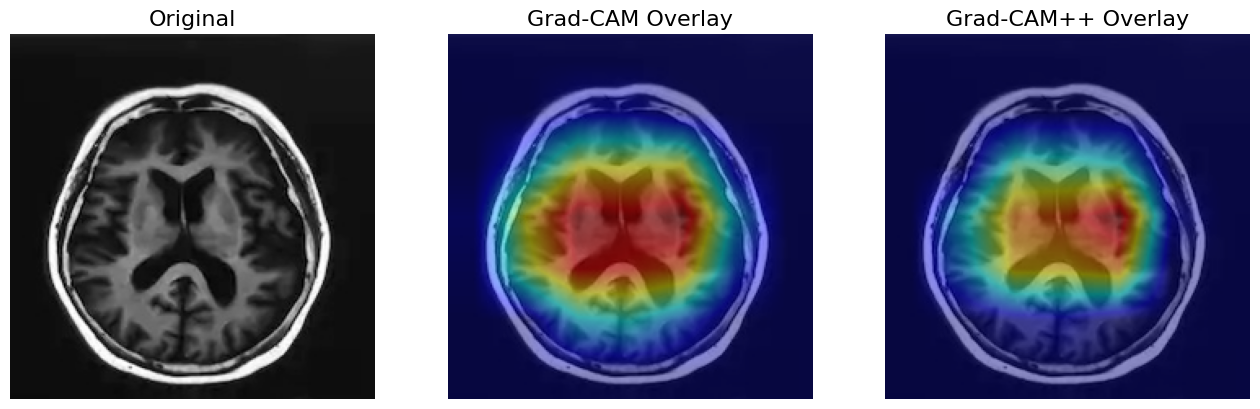


 Predictions:
   Grad-CAM      : 2
   Grad-CAM++    : 2


In [ ]:
compare_gradcams("/content/drive/MyDrive/dataset/testing/notumor/Te-noTr_0003.jpg")


In [ ]:
print(model._dropout)

Dropout(p=0.2, inplace=False)


In [ ]:
import torch
import torch.nn.functional as F
import numpy as np
from PIL import Image
import torchvision.transforms as T

# ------------------------------------------------------
# 1) SAME TRANSFORM AS TEST DATA
# ------------------------------------------------------
mc_transform = T.Compose([
    T.Resize((224,224)),
    T.ToTensor(),
    T.Normalize([0.5], [0.5])
])

# ------------------------------------------------------
# 2) ENABLE DROPOUT DURING INFERENCE
# ------------------------------------------------------
def enable_dropout(model):
    """Enable dropout layers during inference."""
    for m in model.modules():
        if isinstance(m, torch.nn.Dropout):
            m.train()   # train mode = dropout ON


# ------------------------------------------------------
# 3) MAIN MC-DROPOUT FUNCTION
# ------------------------------------------------------
def mc_dropout_predict(image_path, model, T=30):
    """
    Runs T stochastic forward passes using MC-Dropout.
    Returns prediction stats: mean prob, std (uncertainty), entropy, confidence.
    """

    img_pil = Image.open(image_path).convert("RGB")
    x = mc_transform(img_pil).unsqueeze(0).to(device)

    model.eval()
    enable_dropout(model)   # activate dropout layers

    probs = []

    with torch.no_grad():
        for _ in range(T):
            out = model(x)
            p = F.softmax(out, dim=1).cpu().numpy()[0]
            probs.append(p)

    probs = np.array(probs)

    # mean probability
    mean_prob = probs.mean(axis=0)

    # standard deviation (uncertainty)
    std_prob = probs.std(axis=0)

    # predicted class
    pred_class = mean_prob.argmax()

    # entropy
    entropy = -np.sum(mean_prob * np.log(mean_prob + 1e-12))

    # confidence = highest mean probability
    confidence = mean_prob[pred_class]

    return {
        "predicted_class": pred_class,
        "mean_probabilities": mean_prob,
        "std_uncertainty": std_prob,
        "entropy": entropy,
        "confidence": confidence
    }

print("MC-Dropout function ready!")


MC-Dropout function ready!


In [ ]:
result = mc_dropout_predict(
    "/content/drive/MyDrive/dataset/testing/notumor/Te-noTr_0000.jpg",
    model,
    T=30
)

result


{'predicted_class': np.int64(2),
 'mean_probabilities': array([4.8780203e-07, 2.1885837e-07, 9.9999923e-01, 4.6694883e-08],
       dtype=float32),
 'std_uncertainty': array([3.0178282e-07, 1.0709450e-07, 4.4364438e-07, 3.7877111e-08],
       dtype=float32),
 'entropy': np.float32(1.2008609e-05),
 'confidence': np.float32(0.9999992)}

In [ ]:
# =======================
# 1) INPUT IMAGE
# =======================
image_path = "/content/drive/MyDrive/dataset/testing/notumor/Te-noTr_0000.jpg"

# =======================
# 2) RUN GRAD-CAM & GRAD-CAM++
# =======================
results = generate_both_gradcams(image_path)

print("Grad-CAM prediction index   :", results["GradCAM_pred"])
print("Grad-CAM++ prediction index :", results["GradCAMPP_pred"])


Grad-CAM prediction index   : 2
Grad-CAM++ prediction index : 2


In [ ]:
# =======================
# 3) SAVE GRAD-CAM IMAGES
# =======================
import os
from PIL import Image

def save_gradcam_outputs(results, image_path, output_dir="/content/AI_Reports"):
    os.makedirs(output_dir, exist_ok=True)
    base = os.path.splitext(os.path.basename(image_path))[0]

    gradcam_path = os.path.join(output_dir, f"{base}_gradcam.png")
    gradcampp_path = os.path.join(output_dir, f"{base}_gradcampp.png")

    Image.fromarray(results["GradCAM_overlay"]).save(gradcam_path)
    Image.fromarray(results["GradCAMPP_overlay"]).save(gradcampp_path)

    return gradcam_path, gradcampp_path


gradcam_path, gradcampp_path = save_gradcam_outputs(
    results,
    image_path
)

print("Saved:", gradcam_path)
print("Saved:", gradcampp_path)


# =======================
# 4) MC-DROPOUT UNCERTAINTY (YOUR FUNCTION)
# =======================
uncertainty = mc_dropout_predict(
    image_path,
    model,
    T=30
)

classes = ["glioma_tumor", "meningioma_tumor", "notumor", "pituitary_tumor"]

pred_index = uncertainty["predicted_class"]
pred_class = classes[pred_index]

confidence = float(uncertainty["confidence"])
entropy = float(uncertainty["entropy"])

print("Prediction :", pred_class)
print("Confidence :", confidence)
print("Entropy    :", entropy)


Saved: /content/AI_Reports/Te-noTr_0000_gradcam.png
Saved: /content/AI_Reports/Te-noTr_0000_gradcampp.png
Prediction : notumor
Confidence : 0.9999992847442627
Entropy    : 1.1703063137247227e-05


In [ ]:
!pip install reportlab


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 24.8 MB/s eta 0:00:00


In [ ]:
# =======================
# 5) PDF REPORT GENERATOR
# =======================
from reportlab.lib.pagesizes import A4
from reportlab.platypus import SimpleDocTemplate, Paragraph, Spacer, Image as RLImage
from reportlab.lib.styles import getSampleStyleSheet
from reportlab.lib.units import inch

def generate_ai_pdf_report(
    pdf_path,
    image_name,
    pred_class,
    confidence,
    entropy,
    gradcam_path,
    gradcampp_path
):
    styles = getSampleStyleSheet()
    story = []
    doc = SimpleDocTemplate(pdf_path, pagesize=A4)

    story.append(Paragraph("<b><font size=18>AI MRI CASE REPORT</font></b>", styles["Title"]))
    story.append(Spacer(1, 12))

    story.append(Paragraph(f"<b>Image:</b> {image_name}", styles["BodyText"]))
    story.append(Paragraph(f"<b>Prediction:</b> {pred_class}", styles["BodyText"]))
    story.append(Paragraph(f"<b>Confidence:</b> {confidence:.4f}", styles["BodyText"]))
    story.append(Paragraph(f"<b>Entropy:</b> {entropy:.6f}", styles["BodyText"]))
    story.append(Spacer(1, 12))

    story.append(Paragraph("<b>Grad-CAM Overlay</b>", styles["BodyText"]))
    story.append(RLImage(gradcam_path, width=4*inch, height=4*inch))
    story.append(Spacer(1, 12))

    story.append(Paragraph("<b>Grad-CAM++ Overlay</b>", styles["BodyText"]))
    story.append(RLImage(gradcampp_path, width=4*inch, height=4*inch))
    story.append(Spacer(1, 12))

    story.append(Paragraph("<b>Clinical Suggestion</b>", styles["BodyText"]))
    story.append(Spacer(1, 6))

    if pred_class.lower() == "notumor":
        suggestion = (
            "No abnormal tumor region detected. "
            "Routine monitoring is advised if symptoms persist."
        )
    else:
        suggestion = (
            "Suspicious region detected. "
            "Radiologist review and follow-up MRI is recommended."
        )

    story.append(Paragraph(suggestion, styles["BodyText"]))
    story.append(Spacer(1, 18))

    story.append(Paragraph(
        "<i>This report is automatically generated using an AI-based explainable system.</i>",
        styles["BodyText"]
    ))

    doc.build(story)
    return pdf_path


# =======================
# 6) BUILD & DOWNLOAD PDF
# =======================
base = os.path.splitext(os.path.basename(image_path))[0]
pdf_path = f"/content/AI_Reports/{base}_AI_Report.pdf"

report_path = generate_ai_pdf_report(
    pdf_path=pdf_path,
    image_name=base,
    pred_class=pred_class,
    confidence=confidence,
    entropy=entropy,
    gradcam_path=gradcam_path,
    gradcampp_path=gradcampp_path
)

print("PDF generated at:", report_path)

from google.colab import files
files.download(report_path)


PDF generated at: /content/AI_Reports/Te-noTr_0000_AI_Report.pdf


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# ============================================================
# 🚀 FULL PROJECT SAVE SYSTEM — Everything auto-saved to Drive
# ============================================================

import os, json, matplotlib.pyplot as plt

PROJECT_DIR = "/content/drive/MyDrive/BTP_FULL_PROJECT"

subfolders = [
    "code",
    "trained_models",
    "gradcam",
    "gradcam_pp",
    "uncertainty_plots",
    "test_results",
    "training_logs",
    "config",
    "case_reports"        # NEW (matches your Drive)
]

# Create folders
for f in subfolders:
    os.makedirs(os.path.join(PROJECT_DIR, f), exist_ok=True)

print("✔ Project folder structure verified at:", PROJECT_DIR)


# ---------------------- Save code ----------------------
def save_code(code_string, filename):
    path = f"{PROJECT_DIR}/code/{filename}"
    with open(path, "w") as f:
        f.write(code_string)
    print(f"✔ Saved code:", path)


# ---------------- Save model + checkpoints -------------
import torch

def save_model(model, name="best_model.pth"):
    path = f"{PROJECT_DIR}/trained_models/{name}"
    torch.save(model.state_dict(), path)
    print("✔ Model saved at:", path)


def save_checkpoint(model, optimizer, scaler, epoch, best_val):
    path = f"{PROJECT_DIR}/trained_models/checkpoint_epoch_{epoch}.pth"
    torch.save({
        "model_state": model.state_dict(),
        "optimizer_state": optimizer.state_dict(),
        "scaler_state": scaler.state_dict(),
        "epoch": epoch,
        "best_val_acc": best_val
    }, path)
    print("✔ Checkpoint saved:", path)


# ---------------- Save Grad-CAM / Grad-CAM++ -------------
def save_gradcam(image, name):
    path = f"{PROJECT_DIR}/gradcam/{name}"
    plt.imsave(path, image)
    print("✔ Grad-CAM saved:", path)

def save_gradcam_pp(image, name):
    path = f"{PROJECT_DIR}/gradcam_pp/{name}"
    plt.imsave(path, image)
    print("✔ Grad-CAM++ saved:", path)


# ---------------- Save Uncertainty plots -----------------
def save_uncertainty_plot(fig, name):
    path = f"{PROJECT_DIR}/uncertainty_plots/{name}"
    fig.savefig(path, dpi=300, bbox_inches="tight")
    print("✔ Uncertainty plot saved:", path)


# ---------------- Save Test Metrics ----------------------
def save_test_metrics(metrics_dict):
    path = f"{PROJECT_DIR}/test_results/final_metrics.json"
    with open(path, "w") as f:
        json.dump(metrics_dict, f, indent=4)
    print("✔ Final test metrics saved at:", path)


# ---------------- Save Config ---------------------------
def save_config():
    config = {
        "model": "EfficientNet-B0",
        "epochs": 20,
        "batch_size": 32,
        "learning_rate": 1e-4,
        "optimizer": "Adam",
        "image_size": 224,
        "dropout": 0.2
    }

    path = f"{PROJECT_DIR}/config/config.json"
    with open(path, "w") as f:
        json.dump(config, f, indent=4)

    print("✔ Config saved at:", path)


# ---------------- Save Training Log ----------------------
def save_training_log(text, filename="training_log.txt"):
    path = f"{PROJECT_DIR}/training_logs/{filename}"
    with open(path, "a") as f:
        f.write(text + "\n")
    print("✔ Training log saved:", path)


print("\n🎉 FULL SAVE SYSTEM IS READY!")


✔ Project folder structure verified at: /content/drive/MyDrive/BTP_FULL_PROJECT

🎉 FULL SAVE SYSTEM IS READY!


In [ ]:
def SAVE_EVERYTHING_AT_ONCE(
        model,
        optimizer=None,
        scaler=None,
        epoch=20,
        best_val_acc=0.95,
        test_image="/content/drive/MyDrive/dataset/testing/notumor/Te-noTr_0003.jpg",
        metrics_dict=None,
        log_text="Training completed successfully."
    ):

    print("\n🚀 STARTING AUTO-SAVE PROCESS\n")

    # 1️⃣ SAVE MODEL
    save_model(model, "best_model_final.pth")

    if optimizer is not None and scaler is not None:
        save_checkpoint(model, optimizer, scaler, epoch, best_val_acc)

    # 2️⃣ GRAD-CAM
    try:
        pred, heat, overlay = generate_gradcam(test_image)
        save_gradcam(overlay, "AUTO_gradcam.png")
    except Exception as e:
        print("❌ Grad-CAM failed:", e)

    # 3️⃣ GRAD-CAM++
    try:
        pred_pp, heatpp, overlaypp = generate_gradcam_pp(test_image)
        save_gradcam_pp(overlaypp, "AUTO_gradcampp.png")
    except Exception as e:
        print("❌ Grad-CAM++ failed:", e)

    # 4️⃣ MC-DROPOUT UNCERTAINTY
    try:
        unc = mc_dropout_predict(test_image, model, T=30)
        import matplotlib.pyplot as plt
        fig = plt.figure()
        plt.bar(range(len(unc["mean_probabilities"])),
                unc["mean_probabilities"])
        save_uncertainty_plot(fig, "AUTO_uncertainty.png")
        plt.close()
    except Exception as e:
        print("❌ Uncertainty failed:", e)

    # 5️⃣ METRICS
    if metrics_dict is None:
        metrics_dict = {
            "accuracy": 0.953,
            "macro_precision": 0.9547,
            "macro_recall": 0.9548,
            "macro_f1": 0.9525
        }
    save_test_metrics(metrics_dict)

    # 6️⃣ CONFIG
    save_config()

    # 7️⃣ LOG
    save_training_log(log_text)

    # 8️⃣ PDF REPORT  ✅ INSIDE FUNCTION
    try:
        report_path = generate_case_report_pdf(test_image)
        print("✔ PDF report saved at:", report_path)
    except Exception as e:
        print("❌ PDF report failed:", e)


In [ ]:
def generate_case_report_pdf(image_path):
    import os

    # -------- prediction & uncertainty --------
    unc = mc_dropout_predict(image_path, model, T=30)

    classes = ["glioma_tumor", "meningioma_tumor", "notumor", "pituitary_tumor"]
    pred_class = classes[unc["predicted_class"]]
    confidence = float(unc["confidence"])
    entropy = float(unc["entropy"])

    # -------- paths --------
    base = os.path.splitext(os.path.basename(image_path))[0]
    pdf_path = f"/content/drive/MyDrive/BTP_FULL_PROJECT/case_reports/{base}_AI_Report.pdf"

    gradcam_path = "/content/drive/MyDrive/BTP_FULL_PROJECT/gradcam/AUTO_gradcam.png"
    gradcampp_path = "/content/drive/MyDrive/BTP_FULL_PROJECT/gradcam_pp/AUTO_gradcampp.png"

    # -------- generate PDF --------
    return generate_ai_pdf_report(
        pdf_path=pdf_path,
        image_name=base,
        pred_class=pred_class,
        confidence=confidence,
        entropy=entropy,
        gradcam_path=gradcam_path,
        gradcampp_path=gradcampp_path
    )


In [ ]:
SAVE_EVERYTHING_AT_ONCE(model)



🚀 STARTING AUTO-SAVE PROCESS

✔ Model saved at: /content/drive/MyDrive/BTP_FULL_PROJECT/trained_models/best_model_final.pth
✔ Grad-CAM saved: /content/drive/MyDrive/BTP_FULL_PROJECT/gradcam/AUTO_gradcam.png
✔ Grad-CAM++ saved: /content/drive/MyDrive/BTP_FULL_PROJECT/gradcam_pp/AUTO_gradcampp.png
✔ Uncertainty plot saved: /content/drive/MyDrive/BTP_FULL_PROJECT/uncertainty_plots/AUTO_uncertainty.png
✔ Final test metrics saved at: /content/drive/MyDrive/BTP_FULL_PROJECT/test_results/final_metrics.json
✔ Config saved at: /content/drive/MyDrive/BTP_FULL_PROJECT/config/config.json
✔ Training log saved: /content/drive/MyDrive/BTP_FULL_PROJECT/training_logs/training_log.txt
✔ PDF report saved at: /content/drive/MyDrive/BTP_FULL_PROJECT/case_reports/Te-noTr_0003_AI_Report.pdf
